# Example: Open Image Dataset V4 subset as dataset for applications

This example shows:

- Building subset of Open Images Dataset V4 by selecting annotations for simple application.
- Training a simple object detector model borrowed from fast.ai library lecture course.

From [fast.ai](https://www.fast.ai/)'s [Cutting Edge Deep Learning For Coders Part 2](https://course.fast.ai/part2.html), [pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb) is a course notebook that describes very intuitively how to build object detector from scratch.
It starts from training simple CNN classifier, then it replaces head of CNN model to predict a single bounding box and a class.

For training it, a largest bounding box is selected for an image where multiple bboxes are usually annotated.
This example shows how we can do that easily, as well as narrowing classes down to which application needs.

## Key takeaways

- Data selection by annotation bounding box size or classes for specific application.
- OIDV4 application built on top of fast.ai example.
- Example of importance of data selection.

## Requisite

Create your own full annotation beforehand.

In [1]:
# Install dl-cliche in advance: $ pip install git+https://github.com/daisukelab/dl-cliche.git@master
from dlcliche.notebook import *
from od_anno import *

## Creating subset

Now start creating subset of OIDV4, that will have:
- 'Car' and 'Person' classes.
- Leave image's largest bounding box only, and drop all other smaller boxes.
- Resize all images to 640x640.

Depends on:
- You have original dataset under '/mnt/slow_dataset/oidv4'.
- You already have created database for that as 'train_annotations.csv'.
- Destination folder for new subset is '/mnt/dataset/suboidv4/car_person'.

In [2]:
# Subset path => PATH
PATH = Path('/mnt/dataset/suboidv4/car_person')
OIDV4 = Path('/mnt/slow_dataset/oidv4')

In [3]:
my_labels = ['Car', 'Person']

# Load raw ODAnno table.
od = ODAnno(OIDV4/'train_annotations.csv', OIDV4)
print(f'# of raw annotation labels = {len(od)}')

# Extract interested label only.
od.filter_by_label_(my_labels)
print(f'# of interested labels = {len(od)}')

# Filter smaller labels except largest.
od.filter_largest_()
print(f"# of image's biggset labels = {len(od)}")

# of raw annotation labels = 14610229
# of interested labels = 1282796
# of image's biggset labels = 329113


Total number of labels is huge 14M, and we still have too much 1.2M labels for Car and Person.
Then even after narrowing down so that each image has only one label which has largest box, it still have 329k labels.

We need to narrow down again. Now let's check the data.

### Big bounding boxes (size > 0.6)

As you can see images of Person, it's not person but people. In OIDV4, it would be better to avoid big boxes.

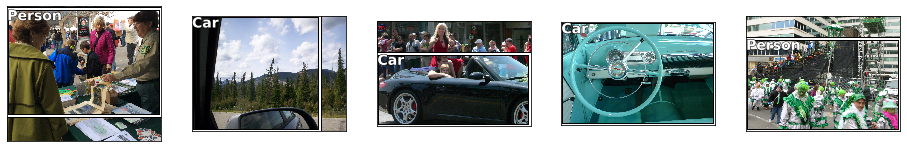

In [5]:
def image_ids(df): return list(df.ImageID)

ids = image_ids(od.anno_df[(0.6 < od.anno_df.Size)])
od.dataset(df=od.anno_df[od.anno_df.ImageID.isin(ids[100:105])]).show(range(5), matrixsize=(5,1), figsize=(16, 8))

### Small bounding boxes (size < 0.02)

There are also too small labels, not suitable for this example.

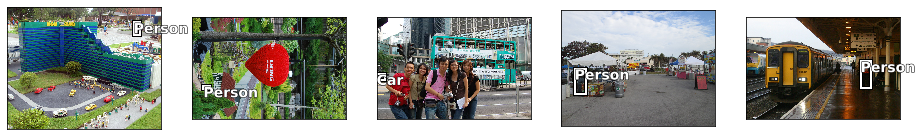

In [5]:
ids = image_ids(od.anno_df[(od.anno_df.Size < 0.02)])
od.dataset(df=od.anno_df[od.anno_df.ImageID.isin(ids[:5])]).show(range(5), matrixsize=(5,1), figsize=(16, 8))

### Modest size (0.3 < size < 0.4)

As shown above, while big labels are really big and almost same as image shape, small ones are too hard to detect.

After making similar check of different sizes, I came up with tentative setting `0.3 < size < 0.4` which has about 30k labels and less # of incorrect Person class labels.

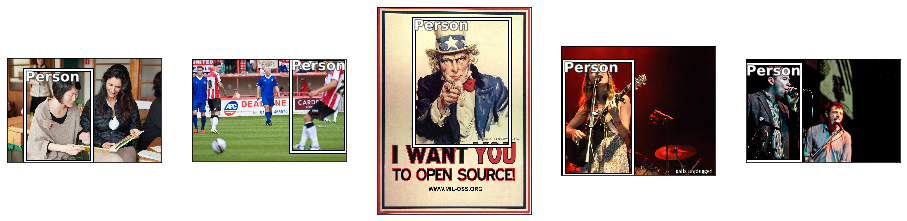

# of labels = 29935
Selected balance so far = {'Car': 6278, 'Person': 23657}


In [7]:
ids = image_ids(od.anno_df[(0.3 < od.anno_df.Size) & (od.anno_df.Size < 0.4)])
df = od.anno_df[od.anno_df.ImageID.isin(ids)]
od.dataset(df=df[:5]).show(range(5), matrixsize=(5,1), figsize=(16, 8))
print(f'# of labels = {len(ids)}')
print_class_balance('Selected balance so far', df.Label)

### Create subset

This resizes and saves __many images__, will __takes 20+ minutes__ depending on your environment.

In [7]:
# Filter by 0.3 <= size < 0.4
od.filter_by_size_(thresh_min=0.3, thresh_max=0.4)

# of images where bbox size is limited = 29935


In [ ]:
od.brew_subset(new_anno_csv=PATH/'annotations.csv',
               dest_folder=PATH/'images', resize_shape=(640,640))

Now annotations.csv and resized images are both created under PATH.

## Load subset and check

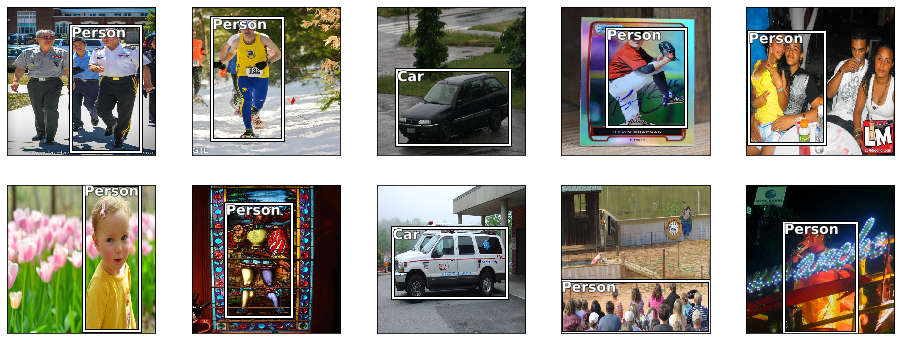

In [4]:
# Load dataframe based object
od = ODAnno(PATH/'annotations.csv', PATH/'images')

# Convert it to dataset
data = od.dataset()

# Show some data
data.show(range(155, 155+10), matrixsize=(5, 2), figsize=(16,6))

## Convert to fast.ai library (v0.7) compatible CSV files

In [5]:
# Nessesory variables: filenames, ids, categories
trn_fns = {str(Path(x).stem):x for x in data.X}
trn_ids = [str(Path(x).stem) for x in data.X]
cats = od.classes

# Nessesory variables: annotation dictionary
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

trn_anno = collections.defaultdict(lambda:[])
for i, o in enumerate(data.y):
    bb = hw_bb(o[0][:4])
    trn_anno[trn_ids[i]].append((bb, o[0][4]))
len(trn_anno), trn_anno[trn_ids[0]]

(29935, [(array([ 73.75488,  74.4    , 638.40544, 353.     ]), 1)])

In [6]:
# Paths for CSV files
HOME = PATH/'tmp'
ensure_folder(HOME)
CSV = HOME/'lrg.csv'
BB_CSV = HOME/'bb.csv'
JPEGS = 'images'

# Make classification CSV
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_anno[o][0][1]] for o in trn_ids]}, columns=['fn','cat'])
df_to_csv_excel_friendly(df, CSV, index=False)

# Make bounding box CSV
bb = np.array([trn_anno[o][0][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df_to_csv_excel_friendly(df, BB_CSV, index=False)

### Borrowing from fast.ai pascal notebook

In [9]:
from fastai.conv_learner import *
from fastai.dataset import *

torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# Model, image size 224x224, batch size
f_model = resnet18
sz=224
bs=64

# For test/validation split
val_idxs = get_cv_idxs(len(trn_fns))

# Raw dataset 1: Classification data source
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

# Raw dataset 2: Bounding box data source with bunch of augmentations
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

# Mixed dataset
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

# Now putting everything in `md`
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [11]:
# Checking bounding box sample
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([  0., 116., 143., 107.])

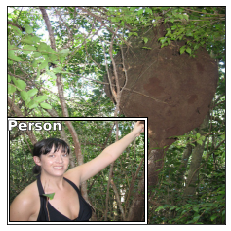

In [12]:
# Visualizing it
ax = show_image(ima)
ax_draw_bbox(ax, b, md2.classes[y[1][idx]])

## Model and learner

In [13]:
# Model definition
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

# Optimizer
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [14]:
# Loss
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 81%|████████  | 303/375 [01:20<00:11,  6.26it/s, loss=107] 

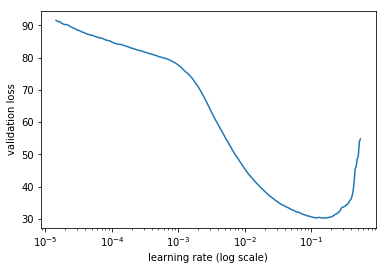

In [15]:
# Find learning rate
learn.lr_find()
learn.sched.plot()

In [16]:
lr=1e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      21.526771  22.877313  0.97862    20.174926 
    1      19.882175  19.501668  0.97979    18.388538       
    2      19.259441  18.968554  0.980792   17.935963       


[18.968554443243413, 0.9807917153833305, 17.935963183546853]

In [ ]:
def visualize_result():
    y = learn.predict()
    x,_ = next(iter(md.val_dl))
    from scipy.special import expit

    for i,ax in enumerate(subplot_matrix(rows=3, columns=4, figsize=(12, 6))):
        ima = md.val_ds.ds.denorm(to_np(x))[i]
        bb = expit(y[i][:4])*224
        b = bb_hw(bb)
        c = np.argmax(y[i][4:])
        ax = show_image(ima, ax=ax)
        ax_draw_bbox(ax, b, md2.classes[c])
    plt.tight_layout()

visualize_result()

After training 3 epochs, it works so so. Training more

 74%|███████▍  | 279/375 [01:09<00:16,  5.77it/s, loss=70.8]

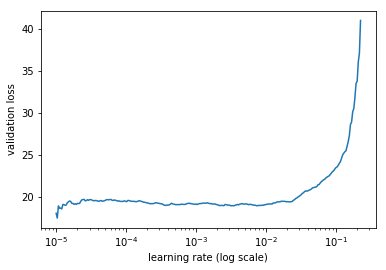

In [19]:
learn.freeze_to(-2)
lrs = np.array([lr/100, lr/10, lr])
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [20]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      16.920029  16.308573  0.981293   15.138193 
    1      15.610048  14.718104  0.984967   13.869233       
    2      14.439022  14.393652  0.985301   13.544269       
    3      13.532991  13.566456  0.98597    12.744514       
    4      12.593432  13.295119  0.988475   12.610638       


[13.295119365706794, 0.9884750292299983, 12.610638383515235]

In [ ]:
visualize_result()

In [22]:
learn.unfreeze()
learn.fit(lrs/20, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      12.66399   13.473363  0.985803   12.598491 
    1      12.480558  13.57099   0.987139   12.78595        
    2      12.185057  13.240672  0.988308   12.43785        
    3      11.662369  13.221018  0.988308   12.437939       
    4      11.370378  13.389573  0.988475   12.564613       
    5      11.281163  13.117957  0.987306   12.246252       
    6      10.944556  13.143551  0.987807   12.276505       
    7      10.883638  13.072158  0.988642   12.216404       
    8      10.730259  13.023693  0.988642   12.202434       
    9      10.491735  13.094233  0.988308   12.268002       


[13.094233402808442, 0.9883080006681142, 12.26800192117253]

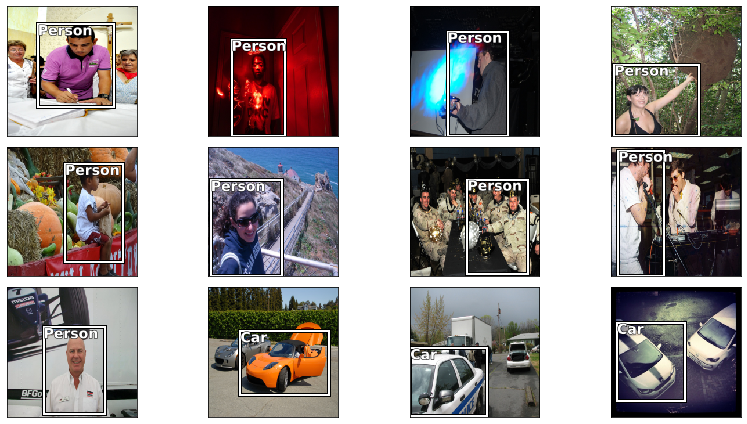

In [23]:
visualize_result()